In [11]:
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image

from IPython.display import Image

In [2]:
# This is a generator that yields batches of preprocessed images
class ImageGenerator(tf.keras.utils.Sequence):    
    
    def __init__(self, img_dir, preprocess_fn=None, batch_size=64):
        
        # Create the dictionary that maps class names into numeric labels 
        folders = os.listdir(img_dir)
        folders.sort()
        indexes = range(len(folders))
        label_map = {key: value for (key, value) in zip(folders, indexes)}
        self.num_classes = len(label_map)
        
        # Create a list of all images in a root folder with associated numeric labels
        labeled_image_list = [(os.path.join(img_dir, folder, image), label_map[folder]) 
                              for folder in folders 
                              for image in os.listdir(os.path.join(img_dir, folder))
                              ]
        # Shuffle the list
        random.shuffle(labeled_image_list)
        # Set image list and associated label list
        self.image_list, self.label_list = zip(*labeled_image_list) 
        # Set batch size
        self.batch_size = batch_size
       
        # Set the pre-processing function passed as a parameter
        self.preprocess_fn = preprocess_fn
        
        # Set number of batches
        self.n_batches = len(self.image_list) // self.batch_size
        if len(self.image_list) % self.batch_size > 0:
            self.n_batches += 1
            
    def __len__(self):
        
        return self.n_batches
    
    def __getitem__(self, index):
        pathnames = self.image_list[index*self.batch_size:(index+1)*self.batch_size]
        images = self.__load_images(pathnames)
        
        return images
    
    # Load a set of images passed as a parameter into a NumPy array
    def __load_images(self, pathnames):
        images = []
        for pathname in pathnames:
            img = image.load_img(pathname, target_size=(224,224,3))
            img = image.img_to_array(img)
            images.append(img)
        images = np.asarray(images)
        if self.preprocess_fn != None:
            images = self.preprocess_fn(images)   
        
        return images
    
    # Return labels in one-hot encoding
    def get_labels(self):
        
        return to_categorical(np.asarray(self.label_list), self.num_classes)
    


In [12]:
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

input_dir = '../datasets/aerialsmall/train/Barren'

files = [os.path.join(input_dir, file) for file in os.listdir(input_dir)]

In [13]:
filenames = files[0:3]
filenames

['../datasets/aerialsmall/train/Barren/ortho_1-1_hn_s_ca025_2016_1_50542.png',
 '../datasets/aerialsmall/train/Barren/ortho_1-1_hn_s_ca025_2016_1_141251.png',
 '../datasets/aerialsmall/train/Barren/ortho_1-1_hn_s_ca025_2016_1_55040.png']

In [17]:
images = []
for file in filenames:
    img = Image.open(file)
    img = np.asarray(img)
    img = resnet50.preprocess_input(img)
    images.append(img)
   

In [20]:
images[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


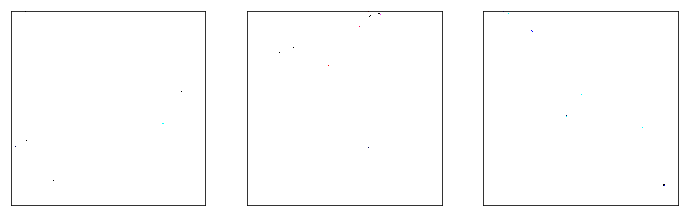

In [18]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, img in zip(axis.flat[0:], images):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)

In [22]:
tf.keras.backend.image_data_format()

'channels_last'

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.applications import resnet50
from tensorflow.keras.regularizers import l1_l2


# Define network
def fcn_classifier(input_shape=(2048,), units=512, classes=6,  l1=0.01, l2=0.01):
    features = Input(shape=input_shape)
    x = Dense(units, activation='relu')(features)
    x = Dropout(0.5)(x)
    y = Dense(classes, activation='softmax', kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    model = Model(inputs=features, outputs=y)
    model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [2]:
model = fcn_classifier()

In [3]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 1,052,166
Trainable params: 1,052,166
Non-trainable params: 0
_________________________________________________________________


In [12]:
trunk = resnet50.ResNet50(
                weights = 'imagenet', 
                input_shape=(224,224,3), 
                include_top = False,
                pooling = 'avg')

In [15]:
stacked = Model(inputs=trunk.input, outputs=model(trunk.output))

In [38]:
stacked.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
from tensorflow.keras.utils import plot_model
import pydot


In [16]:
plot_model(stacked, to_file="model2.png")

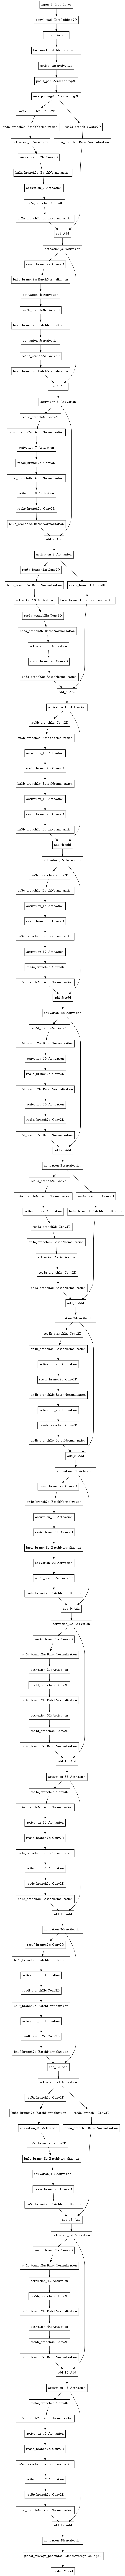

In [18]:
Image("model2.png")

In [21]:
features = Input(shape=(1024,))
x = Dense(128, activation='relu')(features)
x = Dropout(0.5)(x)
y = Dense(6, activation='softmax')(x)
model = Model(inputs=features, outputs=y)

In [25]:
features = Input(shape=(512,))
x = Dense(1024, activation='softmax')(features)
model1 = Model(inputs=features, outputs=x)

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
Total params: 525,312
Trainable params: 525,312
Non-trainable params: 0
_________________________________________________________________


In [26]:
model3 = Model(inputs=model1.input, outputs=model(model1.output))

In [27]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
model_2 (Model)              (None, 6)                 131974    
Total params: 657,286
Trainable params: 657,286
Non-trainable params: 0
_________________________________________________________________
